<div style="text-align: center;">
<h1 style="font-weight: bold; margin: 24px 0; font-size: 3em;">
ESA Climate Change Competition: Forests in a Changing Climate
</h1>
</div>

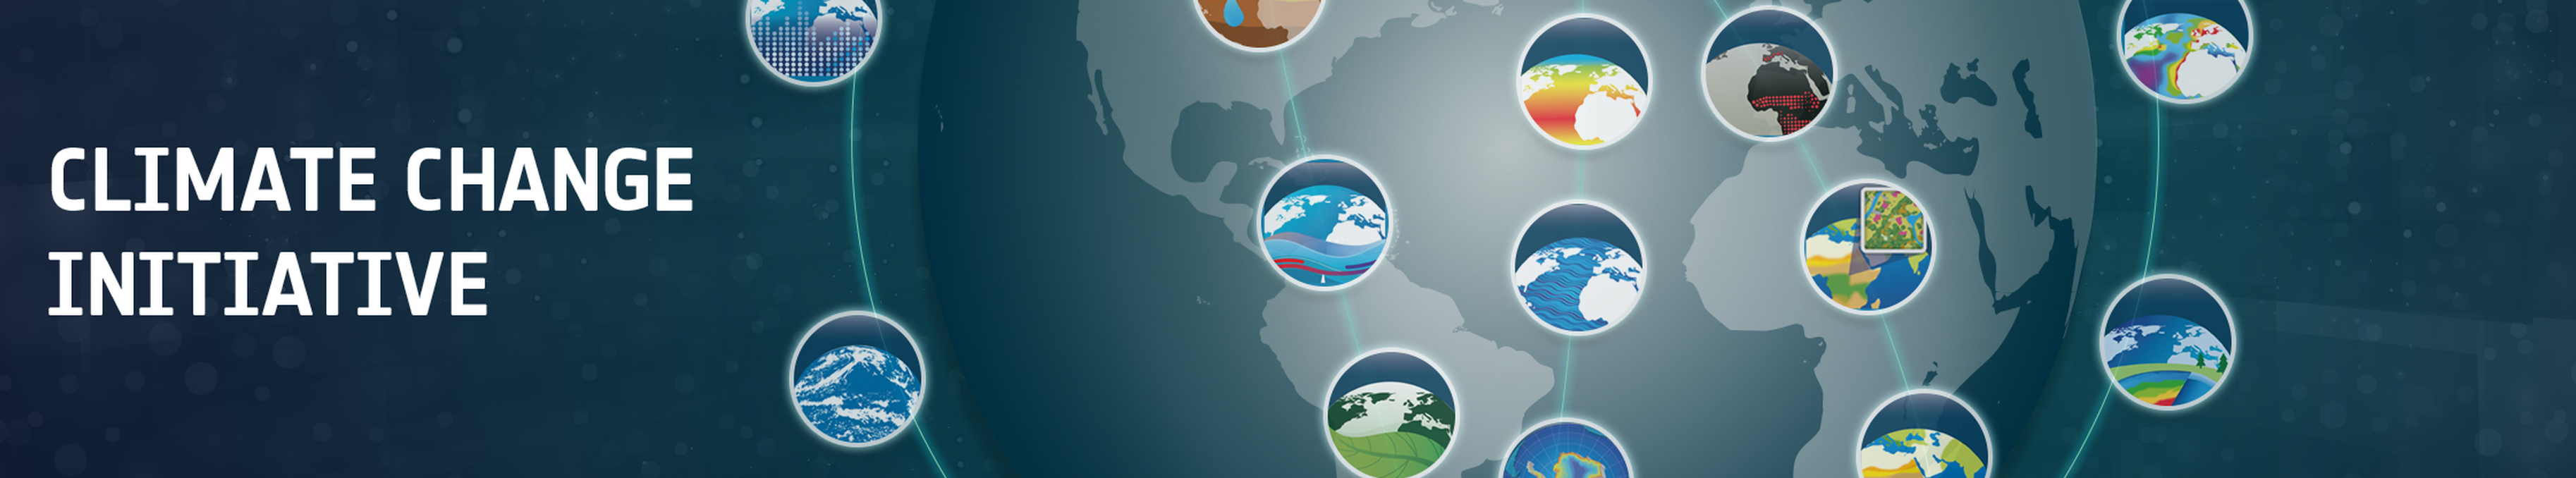

<div style="background-color: #e9ecef;  padding: 10px; border-left: 5px solid #e9ecef;">
<h2 style="margin: 0 0 15px 0; font-size: 2.4em;">Welcome to the ESA Climate Change Communication Competition</h2>

## Explore forests in a changing climate with the ESA CCI datasets

### What You’ll Learn in this Notebook

By working through this notebook, you will:

* Access and explore CCI datasets using the ESA Climate Toolbox
* Create regional and temporal subsets of climate variables
* Visualize different essential climate variables (ECV)

</div>

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">

## Setup & Connect to ESA CCI

In this section, we import the required Python packages to work with ESA Climate Change Initiative (CCI) data. Most notably, we use the [ESA Climate Toolbox](https://esa-climate-toolbox.readthedocs.io/en/latest/) which simplifies access, manipulation, and visualization of CCI datasets in Python.

These packages allow us to:
- Access satellite-based climate data records from ESA.
- Handle geospatial and temporal dimensions efficiently.
- Visualize data with intuitive plotting tools.

📚 For a broader introduction to the toolbox and how to install it, visit:  
🔗 [ESA CCI Climate Toolbox Quick Start](https://esa-climate-toolbox.readthedocs.io/en/latest/quick_start.html#jupyter-notebooks)  
🔗 [ESA Climate Data Toolbox Website](https://climate.esa.int/en/data/toolbox/)

</div>

In [15]:
# ESA Climate Toolbox imports for accessing and plotting ESA CCI data
from esa_climate_toolbox.core import get_op              # Get predefined operations (e.g., time series, averages)
from esa_climate_toolbox.core import list_ecv_datasets   # List available datasets per ECV (Essential Climate Variable)
from esa_climate_toolbox.core import get_store           # Connect to an ESA data store
from esa_climate_toolbox.core import list_datasets       # List all datasets in a store
from esa_climate_toolbox.ops import plot                 # High-level plotting functions for CCI data

# Used for connecting to remote data sources (e.g., ESA CCI ODP)
from xcube.core.store import new_data_store

# For displaying geographic regions interactively (if desired)
from IPython.display import GeoJSON
import shapely.geometry   # Handling geometric objects like bounding boxes

# Core data science libraries
import pandas as pd       # For tabular data handling and time manipulation
import numpy as np        # For numerical operations
import xarray as xr       # For multi-dimensional climate data structures

# Mapping and plotting
import matplotlib.pyplot as plt       # Plotting library
import cartopy.crs as ccrs            # Cartographic projections for spatial data

# Individual colormap creation
from matplotlib.colors import ListedColormap

# Notebook settings
import warnings
warnings.filterwarnings("ignore") # Suppressing warnings to keep notebook output clean
%matplotlib inline

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">

## Zooming In - Defining a Region of Interest

The challenge is focussing on tropic biomass. Thus, we can define a  **region of interest** that captures parts of the tropical forest, e.g. in the Amazon.

We can define smaller regions, e.g. north of Bolivia which has experienced some decline in Biomass over the years due to droughts and fires. 
Another example area is defined around Altamira in Brazil, which experienced a lot deforestation due to agriculture.

</div>

In [18]:
# Set bounding box by defining the longitude minimum, latitude minimum, longitude maximum and latitude maximum
# Example bboxes: 
bbox = (-51.0, -2.8, -50.0, -2) # Altamira region

# bbox = (-63, -15.5, -52, -9) # Larger bounding box -> longer computation time
 
# Display bounding box for reference
GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">

## Using the ESA Climate Toolbox

The ESA Climate Toolbox provides direct access to the **ESA Climate Data Store**, which hosts harmonized satellite-based climate data records produced under the **ESA Climate Change Initiative (CCI)**.

In this step, we establish a connection to the data store so we can browse and open datasets. This connection allows us to access data **without having to download files manually** — a convenient way to explore and analyze large geospatial datasets in cloud-friendly formats such as **Zarr** or **Kerchunk**.

The data store includes a wide range of essential climate variables (ECVs), such as biomass, land surface temperature, burned areas, and soil moisture.

📘 Learn more about available datasets:  
🔗 [ESA Climate Data Toolbox – Quick Start Guide](https://esa-climate-toolbox.readthedocs.io/en/latest/quick_start.html#data-access)

First, we explore how to access the biomass data from the ESA Climate Change Initiative (CCI) data store. This includes identifying datasets of interest, understanding their metadata, and preparing for subsequent analysis.

</div>

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">
    
## Explore the Biomass Dataset
Identify the biomass datasets which are available for access. The `list_ecv_datasets` command returns the names of datasets for a given ECV. 

</div>

In [20]:
# list_ecv_datasets("biomass")

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">


### Background: zarr & kerchunk & NetCDF format
For some data it might be a good idea to use the zarr or kerchunk format, as data loading will be much faster.
Several CCI data records are available in these formats as they have some advantages. 
Zarr is ideal for new datasets that will be frequently accessed, updated, or analyzed and it is suitable for large-scale distributed processing in cloud-native workflows.
Kerchunk is best for efficiently accessing legacy data formats (e.g., NetCDF, GRIB) stored in object stores without converting them and useful when data duplication must be avoided.
NetCDF, while widely used and highly compatible with scientific tools, is less optimized for cloud-native workflows and accessing large datasets efficiently, making it better suited for smaller-scale, traditional file-based analysis.

| **Feature**                      | **Zarr**                                     | **Kerchunk**                                 | **NetCDF**                                                |
|----------------------------------|----------------------------------------------|----------------------------------------------|-----------------------------------------------------------|
| **Storage Format**               | Self-contained, new format                   | Wrapper for existing formats                 | Traditional file-based format                             |
| **Cloud-Native**                 | Yes                                          | Yes                                          | No                                                        |
| **Efficiency**                   | Good for accessing subsets                   | Great for legacy data in object stores       | Efficient for small to medium files                       |
| **Compression**                  | Supports multiple algorithms                 | Depends on underlying format                 | Limited to format-specific methods                        |
| **Metadata Handling**            | Embedded metadata                            | External JSON index                          | Embedded in file                                          |
| **Read/Write Access**            | Supports both                                | Read-only                                    | Read and write                                            |
| **Setup Overhead**               | None, works out of the box                   | Requires pre-generated JSON indices          | None, but slower for large datasets                       |
| **Storage Duplication**          | Requires duplicating data                    | Minimal, uses existing files                 | Minimal, as data is stored in single files                |
| **Performance**                  | Optimized for chunk-based access             | Slight overhead for index lookup             | Can be slow for very large files                          |
| **Selective loading**            | Not supported, entire dataset must be loaded | Not supported, entire dataset must be loaded | Allows selecting variables and time ranges before loading |

</div>

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">

## Load & Visualise the Biomass Data
### Define the Dataset ID
To work with a specific ESA CCI dataset, we need to specify its **dataset ID**. This unique identifier tells the toolbox which variable and product we want to access.

In this section, we are using a the biomass zarr file. The latest biomass zarr file is only available unti 2020, however, the file will soon be updated. 

You can find the variables of the products under **data_vars**. For the biomass, we will use the variable **agb** which is the abbreviation for ***above-ground biomass***. 

First, we define the dataset ID and the store from which we retrieve the data (for the biomass zarr file it is `esa-cci-zarr`, if you choose to call the netcdf file, use the `esa-cci`store). With the command `describe_data`, we can have a look at the structure of the file, such as time, dimension and the variable stored within.

In [21]:
# Uncomment the next line, if you want to use the cci store to call a netcdf file
# cci_store = new_data_store("esa-cci")

# Defining the esa cci zarr store
cci_zarr_store = new_data_store("esa-cci-zarr")

# Defining the data id (see list above from the command list_ecv_datasets
data_id = 'ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2020-fv4.0.zarr'

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">

### Describe the Dataset (Check Available Variables and Metadata)

Before loading the full dataset, it’s helpful to **inspect the metadata** to understand its structure. This includes:

- Available variables (e.g., **above ground biomass** (agb), uncertainty estimates)
- Temporal and spatial coverage
- Data format and structure

This step ensures we know what the dataset contains and how to work with it. It also helps confirm that the variable we want to plot or analyze is actually included.

🛠️ Tip: You can use the description to verify variable names, dimensions (e.g., `lat`, `lon`, `time`), and time coverage.

📘 More on dataset structure:  
🔗 [ESA Climate Toolbox – Data Access](https://esa-climate-toolbox.readthedocs.io/en/latest/quick_start.html#accessing-data)
</div>

In [22]:
# Uncomment the next line if you are using the netcdf file
# cci_store.describe_data(data_id)

# Checking the data structure of the chosen file
cci_zarr_store.describe_data(data_id)

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">

### Open the Dataset

Now we open the dataset using the zarr. When using the zarr format, the whole dataset is loaded. We will later use the cci-store where we can define the variables and time range we are interested in. For now, let's load the entire dataset:
</div>

In [26]:
biomass_ds = cci_zarr_store.open_data(
    data_id=data_id
)

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">

### Create a Spacial Subset of the Dataset:

To focus our analysis on the defined region above, we extract a **spatial subset** from the global dataset.
Using the bounding box we defined earlier, the function `subset_spatial` filters the dataset to include only the relevant area.
This helps reduce data volume and enables more targeted visualizations and calculations in the following steps.

If you would like to retrieve a list of all available operation tools, you can execute:

`from esa_climate_toolbox.core import list_operations`

`list_operations()`

</div>

In [27]:
subset_spatial_op = get_op('subset_spatial')
biomass_sub = subset_spatial_op(ds=biomass_ds, region=bbox)

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">

### Visualize the Results

We now create a simple map plot of the spatial subset and loop it across the years. 
This allows us to explore the spatial patterns of the biomass.

For more interactive and advanced visualizations, check out the [ESA Climate Toolbox](https://climate.esa.int/en/data/toolbox/) or the [Toolbox documentation](https://esa-climate-toolbox.readthedocs.io/en/latest/quick_start.html#jupyter-notebooks).

Processing year 2018...


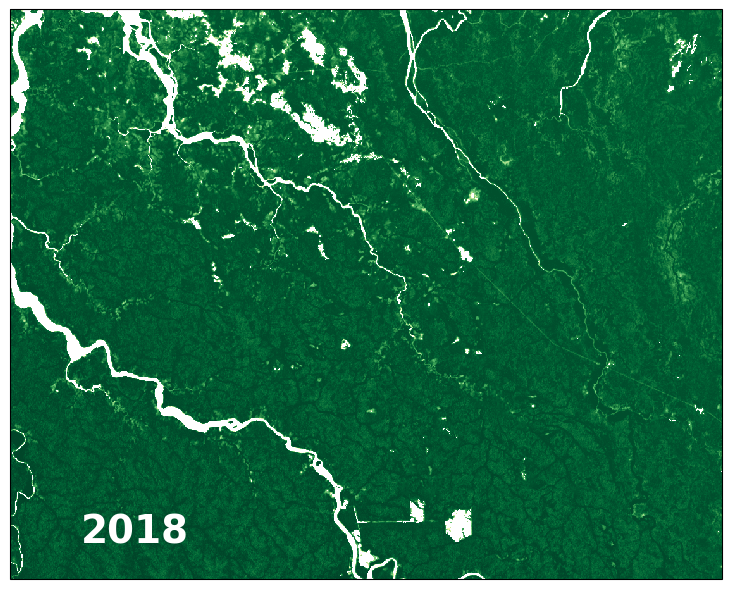

Processing year 2019...


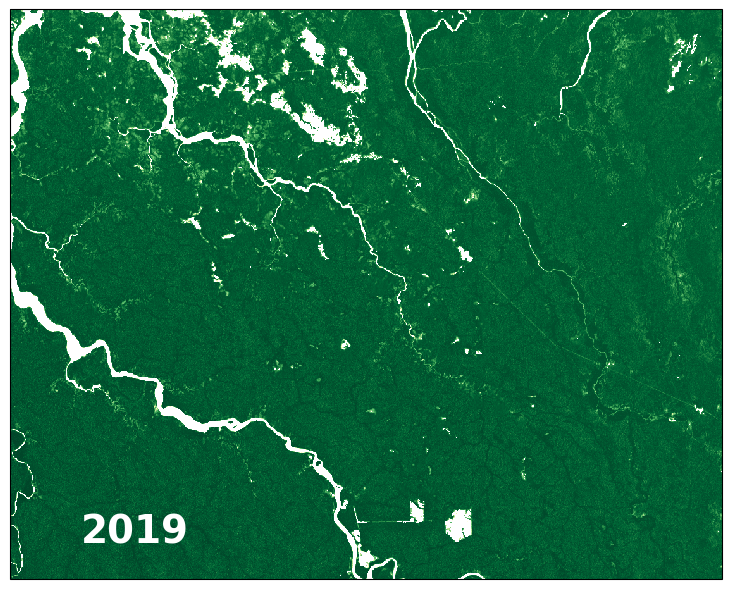

Processing year 2020...


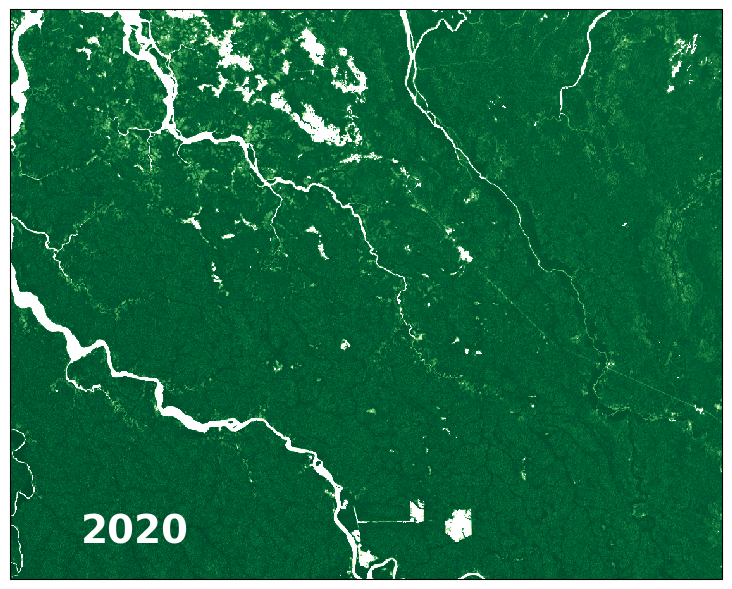

In [28]:
import os
script_dir = os.getcwd()  # Gets current working directory
png_dir = os.path.join(script_dir, 'Biomass/')
# Create directory if it doesn't exist
os.makedirs(png_dir, exist_ok=True)

# Define years to loop through
years = range(2018, 2021)  # you can adapt the range here according to data availability; if you want to include 2020, you need to end the range at 2021

for year in years:
    print(f"Processing year {year}...")
    
    # Create timestep for biomass (yearly data)
    timestep = f'{year}-01-01'
    
    # Load and extract the biomass data
    biomass = biomass_sub["agb"].sel(time=timestep, method='nearest').compute()
    time_str = biomass_sub['time'].sel(time=timestep, method='nearest').dt.strftime('%Y').item()
    lat = biomass_sub["lat"]
    lon = biomass_sub["lon"]
    
    fig = plt.figure(figsize=(12, 6))
    
    # Create two axes with the same projection
    ax = plt.axes(projection=ccrs.PlateCarree())
  
    # Plot biomass, mask the data and only use positive values
    masked_biomass = np.ma.masked_where(biomass <= 0, biomass)
    mesh_biomass = ax.pcolormesh(
        lon, lat, masked_biomass,
        cmap="YlGn", shading="auto",
        norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=np.nanpercentile(biomass, 99)) # avoid outliers to darken the colormap unneccessarily by using np.nanpercentile
    )
    # Hide grid lines 
    ax.grid(False)
     # Add year label in upper-right corner
    ax.text(
        -50.9,-2.75, # define location for the text
        str(year),
        color='white',
        fontsize=28,
        fontweight='bold',
        transform=ccrs.PlateCarree()
    ) 
    # Save with year in filename
    plt.savefig(os.path.join(png_dir, f'Biomass_{year}.png'), bbox_inches='tight')
    plt.show() # show the plot below the cell
    plt.close()  # Close figure to free memory
    

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">

### Create a Gif from the Pictures

Next, we show you how to create a small animation from the produced pictures and save it as gif. This obviously only makes sense if you have produced several plots and saved them in one folder. 

In [8]:
from PIL import Image
import os
png_dir = './Biomass/'

images = []
for filename in sorted(os.listdir(png_dir)):
    if filename.endswith('.png'):
        img = Image.open(os.path.join(png_dir, filename))
        images.append(img)

images[0].save(
    './biomass.gif',
    save_all=True,
    append_images=images[1:],
    duration=500,  # milliseconds per frame adjust for your purpose
    loop=0
)

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">

# Land Cover
## Load and Visualise the Land Cover Dataset
Next, we are loading the land cover dataset. The procedure is the same as for the biomass data. 

The land cover classes and their colours are defined below and can be found in the 🔗 [Product User Guide](https://climate.esa.int/media/documents/CCI_Land_Cover_PUG_v2.0.pdf). 

###  Land Cover Classification System (LCCS) - the CCI-Land Cover legend
| VALUE | LCCS LABEL |
|-------|------------|
| 10    | Rainfed shrub crops // Rainfed tree crops // Rainfed herbaceous crops |
| 11    | Rainfed herbaceous crops |
| 12    | Rainfed shrub crops // Rainfed tree crops |
| 20    | Irrigated tree crops // Irrigated shrub crops // Irrigated herbaceous crops // Post-flooding cultivation of herbaceous crops |
| 30    | Cultivated and managed terrestrial areas / Natural and semi-natural primarily terrestrial vegetation |
| 40    | Natural and semi-natural primarily terrestrial vegetation / Cultivated and managed terrestrial areas |
| 50    | Broadleaved evergreen closed to open trees // Broadleaved semi-deciduous closed to open trees |
| 60    | Broadleaved deciduous closed to open trees |
| 61    | Broadleaved deciduous closed (100-40%) trees |
| 62    | Broadleaved deciduous open (40-(20-10)%) trees |
| 70    | Needleleaved evergreen closed to open trees |
| 71    | Needleleaved evergreen closed (100-40%) trees |
| 72    | Needleleaved evergreen open (40-(20-10)%) trees |
| 80    | Needleleaved deciduous closed to open trees |
| 81    | Needleleaved deciduous closed (100-40%) trees |
| 82    | Needleleaved deciduous open (40-(20-10)%) trees |
| 90    | Broadleaved closed to open trees / Needleleaved closed to open trees |
| 100   | Closed to open trees / Closed to open shrubland (thicket) // Herbaceous closed to open vegetation |
| 110   | Herbaceous closed to open vegetation // Closed to open trees / Closed to open shrubland (thicket) |
| 120   | Broadleaved closed to open shrubland (thicket) |
| 121   | Broadleaved Evergreen Closed to Open Thicket // Needleleaved Evergreen Closed to Open Thicket |
| 122   | Broadleaved Deciduous Closed to Open Thicket // Needleleaved Deciduous Closed to Open Thicket |
| 130   | Herbaceous closed to very open vegetation 21453 A2A20 |
| 140   | Closed to open lichens/mosses |
| 150   | Sparse trees // Herbaceous sparse vegetation // Sparse shrubs |
| 151   | Sparse Trees |
| 152   | Sparse Shrubs |
| 153   | Herbaceous Sparse Vegetation |
| 160   | Closed to open (100-40%) broadleaved trees on temporarily flooded land, water quality: fresh water // Closed to open (100-40%) broadleaved trees on permanently flooded land, water quality: fresh water |
| 170   | Closed to open (100-40%) broadleaved trees on permanently flooded land (with daily variations), water quality: saline water // Closed to open (100-40%) broadleaved trees on permanently flooded land (with daily variations), water quality: brackish water // Closed to open (100-40%) semi-deciduous shrubland on permanently flooded land (with daily variations), water quality: saline water // Closed to open (100-40%) semi-deciduous shrubland on permanently flooded land (with daily variations), water quality: brackish water |
| 180   | Closed to open shrubs on permanently flooded land // Closed to open herbaceous vegetation on permanently flooded land // Closed to open shrubs on temporarily flooded land // Closed to open herbaceous vegetation on temporarily flooded land // Closed to open shrubs on waterlogged soil // Closed to open herbaceous vegetation on waterlogged soil (Water quality: fresh, brackish or saline water) |
| 190   | Artificial surfaces and associated areas |
| 200   | Bare areas |
| 201   | Consolidated Material(s) |
| 202   | Unconsolidated Material(s) |
| 210   | Natural water bodies // Artificial water bodies |
| 220   | Artificial perennial snow // Artificial perennial ice // Perennial snow // Perennial ice |


Next, we define the class IDs, their names and the correct colours for the plotting.
</div>

In [29]:
# Define the LCCS colours according to their ID and names
class_ids = [
    10, 11, 12, 20, 30, 40,           # Cultivated areas
    50, 60, 61, 62,                  # Broadleaved trees
    70, 71, 72,                      # Needleleaved evergreen trees
    80, 81, 82,                      # Needleleaved deciduous trees
    90, 100, 110,                    # Mixed vegetation
    120, 121, 122,                   # Shrubland
    130, 140,                        # Herbaceous and lichens/mosses
    150, 151, 152, 153,              # Sparse vegetation
    160, 170, 180,                   # Aquatic vegetation
    190,                             # Artificial surfaces
    200, 201, 202,                   # Bare areas
    210, 220                         # Water bodies, snow and ice
]
class_names = [
    "Rainfed crops",                                   # 10
    "Rainfed herbaceous crops",                        # 11
    "Rainfed shrub/tree crops",                        # 12
    "Irrigated crops",                                 # 20
    "Cropland/Natural vegetation mosaic",              # 30
    "Natural vegetation/Cropland mosaic",              # 40
    "Broadleaved evergreen/semi-deciduous trees",      # 50
    "Broadleaved deciduous trees",                     # 60
    "Broadleaved deciduous closed trees",              # 61
    "Broadleaved deciduous open trees",                # 62
    "Needleleaved evergreen trees",                    # 70
    "Needleleaved evergreen closed trees",             # 71
    "Needleleaved evergreen open trees",               # 72
    "Needleleaved deciduous trees",                    # 80
    "Needleleaved deciduous closed trees",             # 81
    "Needleleaved deciduous open trees",               # 82
    "Mixed broadleaved/needleleaved trees",            # 90
    "Mixed trees/shrubland/herbaceous",                # 100
    "Herbaceous/trees/shrubland",                      # 110
    "Shrubland",                                       # 120
    "Evergreen shrubland",                             # 121
    "Deciduous shrubland",                             # 122
    "Grassland",                                       # 130
    "Lichens and mosses",                              # 140
    "Sparse vegetation",                               # 150
    "Sparse trees",                                    # 151
    "Sparse shrubs",                                   # 152
    "Sparse herbaceous",                               # 153
    "Flooded trees (fresh water)",                     # 160
    "Flooded trees (saline/brackish water)",           # 170
    "Flooded shrubs/herbaceous",                       # 180
    "Urban areas",                                     # 190
    "Bare areas",                                      # 200
    "Consolidated bare areas",                         # 201
    "Unconsolidated bare areas",                       # 202
    "Water bodies",                                    # 210
    "Snow and ice"                                     # 220
]

colors = [
    "#ffff64", "#90ee90", "#228b22", "#ffd700",        # Crops (10-12, 20)
    "#daa520", "#b8860b",                              # Crop mosaics (30, 40)
    "#006400", "#228b22", "#32cd32", "#7cfc00",        # Broadleaved trees (50, 60-62)
    "#2f4f4f", "#708090", "#778899",                   # Needleleaved evergreen (70-72)
    "#8b4513", "#a0522d", "#cd853f",                   # Needleleaved deciduous (80-82)
    "#556b2f", "#6b8e23", "#9acd32",                   # Mixed/shrubland (90, 100, 110)
    "#d2691e", "#ff8c00", "#ffa500",                   # Shrubland (120-122)
    "#adff2f", "#bdb76b",                              # Grassland, lichens (130, 140)
    "#f5deb3", "#deb887", "#d2b48c", "#bc8f8f",        # Sparse vegetation (150-153)
    "#4682b4", "#5f9ea0", "#20b2aa",                   # Wetlands (160, 170, 180)
    "#dc143c",                                         # Urban (190)
    "#f5f5dc", "#fff8dc", "#faebd7",                   # Bare areas (200-202)
    "#4169e1", "#ffffff"                               # Water, snow/ice (210, 220)
]


<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">
Now let's load the dataset and build the subset for the defined bbox. 
</div>

In [31]:
# Land Cover data ID
data_id = 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr' 

lc_ds = cci_zarr_store.open_data(
    data_id = data_id
)
# Building the subset 
subset_spatial_op = get_op('subset_spatial')
lc_sub = subset_spatial_op(ds=lc_ds, region=bbox)

Processing year 2018...


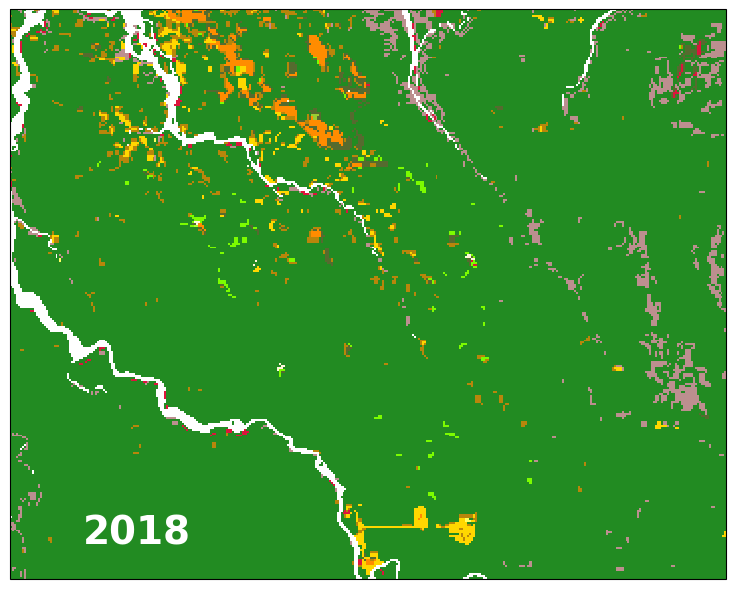

Processing year 2019...


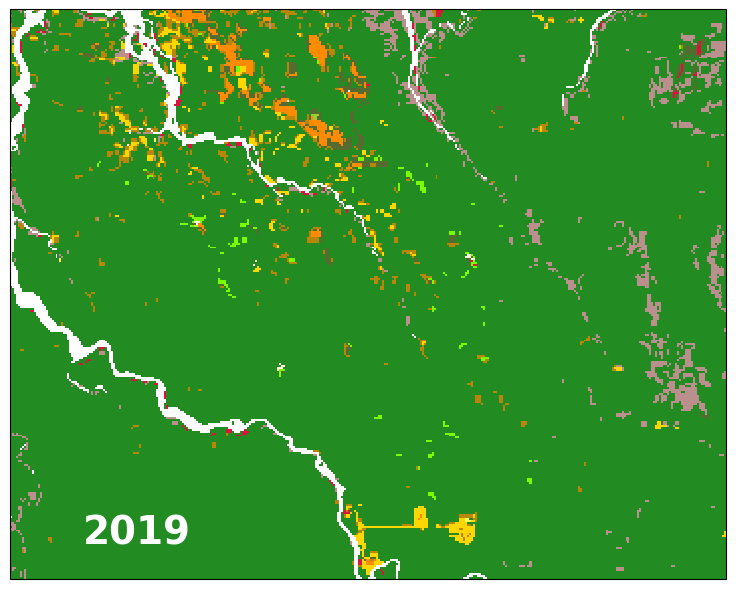

Processing year 2020...


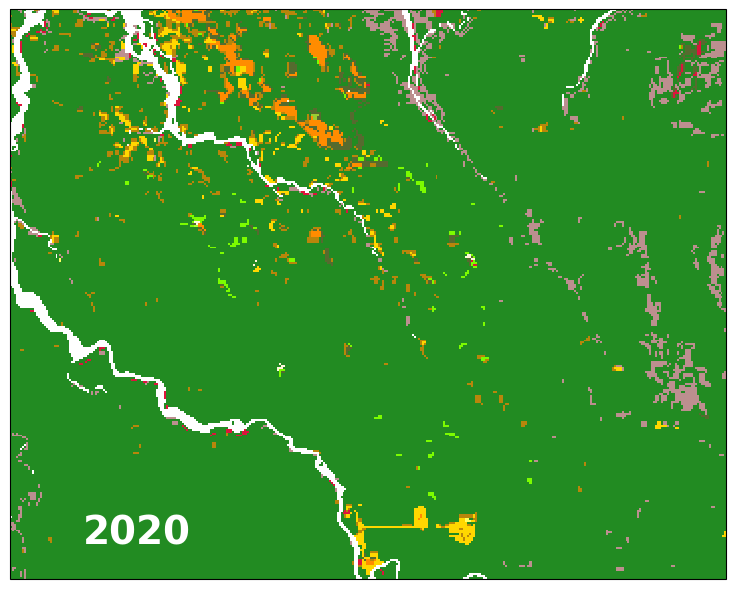

In [34]:
# Define years to loop through
years = range(2018, 2021)  # adapt as needed
cmap = ListedColormap(colors)

for year in years:
    print(f"Processing year {year}...")
    
    # Create timestep for biomass (yearly data)
    timestep = f'{year}-01-01'
    
    # Load and extract the biomass data
    lc = lc_sub["lccs_class"].sel(time=timestep, method='nearest').compute()
    time_str = lc_sub['time'].sel(time=timestep, method='nearest').dt.strftime('%Y').item()
    lat = lc_sub["lat"]
    lon = lc_sub["lon"]
    
    fig = plt.figure(figsize=(12, 6))
    
    # Create two axes with the same projection
    ax = plt.axes(projection=ccrs.PlateCarree())
  
    # Plot lc on first axis
    mesh_biomass = ax.pcolormesh(
        lon, lat, lc,
        cmap=cmap, shading="auto",
    )
    # Hide grid lines
    ax.grid(False)
     # Add year label in upper-right corner
    # Add year label in upper-right corner
    ax.text(
        -50.9,-2.75, # define location for the text
        str(year),
        color='white',
        fontsize=28,
        fontweight='bold',
        transform=ccrs.PlateCarree()
    )  
    
    # Add custom legend
    from matplotlib.patches import Patch
    # Find the unique land cover classes in the current plotted area to reduce the legend entries
    visible_classes = np.unique(lc.values)

    # Build legend only for classes present in the plot
    legend_handles = [
        Patch(color=colors[class_ids.index(cid)], label=class_names[class_ids.index(cid)])
        for cid in visible_classes if cid in class_ids
    ]
    
    #ax.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc="upper right", ncol=2,fontsize=8)
    plt.show()
        
    # Save with year in filename
    #plt.savefig(f'./LandCover_{year}.png', bbox_inches='tight')
    #plt.close()  # Close figure to free memory
   

<div style="background-color: #F5D6AD; padding: 10px; border-radius: 5px;">

## Load Other Essential Climate Variables
    
Below is a list of datafiles you can use for other ECVs which might be of interest when looking at biomass loss. 
If you need inspiration or tipps on how to visualise the parameters, you can have a look at the individual Jupyter Notebooks for each ECV either in the Example Explorer or on 🔗 [GitHub](https://github.com/esa-cci/cci-notebooks/tree/main/notebooks).

### Fire
`data_id = 'ESACCI-L4_FIRE-BA-MODIS-2001-2022-fv5.1.zarr'`

### Clouds
`data_id = 'ESACCI-L3C_CLOUD-CLD_PRODUCTS-AVHRR_NOAA-1982-2016-fv3.0.zarr'`

### Land Surface Temperature (LST)
`data_id = 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1MONTHLY_DAY-1995-2020-fv3.00.zarr'`

### Greenhouse Gases (GHG) - CO2
`data_id = 'ESACCI-GHG-L2-CO2-SCIAMACHY-WFMD-2002-2012-fv1.zarr'`

### Water Vapour 
`data_id = 'ESACCI-WATERVAPOUR-L3C-TCWV-meris-005deg-2002-2017-fv3.2.zarr'`

</div>